### import required libraries and dataset

In [39]:
from datasets import load_dataset #datasets 
from PIL import Image #pillow to manipulate image
import io
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification
from torchvision.transforms import ToPILImage
from IPython.display import display

#loding the mri dataset from huggingface
dataset = load_dataset("Falah/Alzheimer_MRI")
dataset = dataset['train'].train_test_split(test_size=0.2)  # 80% train, 20% validation


In [40]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")


PyTorch version: 2.3.1+cu121
CUDA available: True
CUDA version: 12.1


### prepocessing dataset for efficientnet-b0 model


In [41]:

# Load the image processor for EfficientNet-B0
image_processor = AutoImageProcessor.from_pretrained("google/efficientnet-b0")

def preprocess_images(examples):
    """
    Preprocesses a batch of images using the EfficientNet-B0 image processor.
    Returns:
        The preprocessed batch of images, including resized, normalized pixel values, 
        and a channel dimension for grayscale images.
    """
    images = [np.array(image) for image in examples["image"]]
    
    # Convert grayscale to RGB by repeating the single channel 3 times
    images = [np.repeat(image[:, :, np.newaxis], 3, axis=2) for image in images]
    
    images = image_processor(images=images, return_tensors="pt")
    images['labels'] = examples['label']
    return images

# Apply preprocessing to the dataset
transformed_dataset = dataset.map(preprocess_images, batched=True)
train_dataset = transformed_dataset['train']
val_dataset = transformed_dataset['test']

In [42]:
print(transformed_dataset['train'].column_names)


['image', 'label', 'pixel_values', 'labels']


Image 1, Label: 3


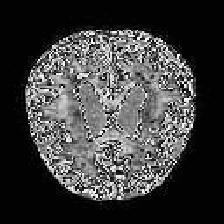

Image 2, Label: 2


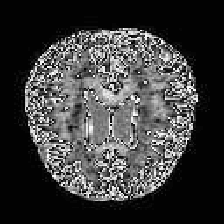

Image 3, Label: 2


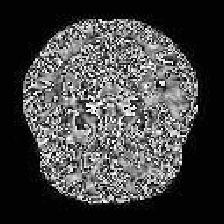

Image 4, Label: 3


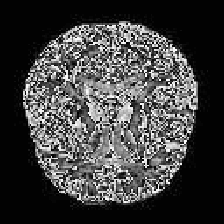

Image 5, Label: 2


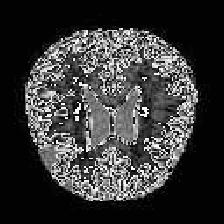

In [5]:
# Display a few examples from the TRAINING set
num_examples_to_display = 5
to_pil_image = ToPILImage() # Create a ToPILImage transform object
for i in range(num_examples_to_display):
    example = train_dataset[i]  
    image = example['pixel_values'].squeeze(0)   # Remove batch dimension (1,C,H,W) -> (C,H,W) 
    label = example['labels']
    print(f"Image {i + 1}, Label: {label}")
    display(to_pil_image(image)) 


Image 1, Label: 3


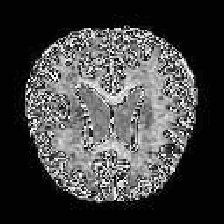

Image 2, Label: 2


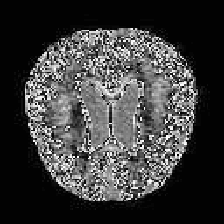

Image 3, Label: 3


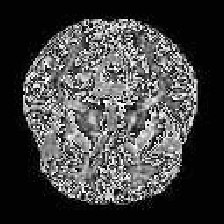

Image 4, Label: 3


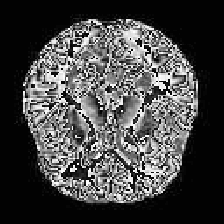

Image 5, Label: 3


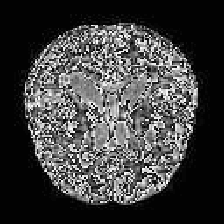

In [6]:
# Display a few examples from the validation set
num_examples_to_display = 5
to_pil_image = ToPILImage() # Create a ToPILImage transform object
for i in range(num_examples_to_display):
    example = val_dataset[i]  
    image = example['pixel_values'].squeeze(0)   # Remove batch dimension (1,C,H,W) -> (C,H,W) 
    label = example['labels']
    print(f"Image {i + 1}, Label: {label}")
    display(to_pil_image(image)) 


###  Fine-tune EfficientNet-B0 on GPU and hub upload

In [45]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

# Define label2id and id2label dictionaries
labels = transformed_dataset["train"].features["label"].names
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}

# Loading the pretrained model with proper configuration
alz_model = AutoModelForImageClassification.from_pretrained(
    "google/efficientnet-b0",
    ignore_mismatched_sizes=True,
    num_labels=len(labels),  # Number of classes
    label2id=label2id,
    id2label=id2label,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alz_model.to(device)

# Define the training arguments
trainingArguments = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=25,
    fp16=True,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id="devadethanr/alz_model",
    hub_strategy="every_save"
)

# Define the Trainer object
trainer = Trainer(
    model=alz_model,
    args=trainingArguments,
    data_collator=None,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train alz_model
trainer.train()
alz_model.save_pretrained("alz_model")


Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([4, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/12800 [00:00<?, ?it/s]

{'loss': 0.955, 'grad_norm': 12.582773208618164, 'learning_rate': 4.8015625e-05, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.7914919853210449, 'eval_runtime': 110.7708, 'eval_samples_per_second': 9.244, 'eval_steps_per_second': 0.289, 'epoch': 1.0}
{'loss': 0.6936, 'grad_norm': 18.10804557800293, 'learning_rate': 4.6019531250000006e-05, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.6403047442436218, 'eval_runtime': 110.9368, 'eval_samples_per_second': 9.23, 'eval_steps_per_second': 0.288, 'epoch': 2.0}
{'loss': 0.5088, 'grad_norm': 30.87863540649414, 'learning_rate': 4.401953125e-05, 'epoch': 3.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.540939450263977, 'eval_runtime': 99.2146, 'eval_samples_per_second': 10.321, 'eval_steps_per_second': 0.323, 'epoch': 3.0}
{'loss': 0.3451, 'grad_norm': 7.9331159591674805, 'learning_rate': 4.20234375e-05, 'epoch': 4.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.4149691164493561, 'eval_runtime': 94.4161, 'eval_samples_per_second': 10.846, 'eval_steps_per_second': 0.339, 'epoch': 4.0}
{'loss': 0.2583, 'grad_norm': 58.11539840698242, 'learning_rate': 4.00234375e-05, 'epoch': 5.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.47272828221321106, 'eval_runtime': 147.0598, 'eval_samples_per_second': 6.963, 'eval_steps_per_second': 0.218, 'epoch': 5.0}
{'loss': 0.1991, 'grad_norm': 6.721988677978516, 'learning_rate': 3.8023437500000005e-05, 'epoch': 6.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.336900532245636, 'eval_runtime': 138.382, 'eval_samples_per_second': 7.4, 'eval_steps_per_second': 0.231, 'epoch': 6.0}
{'loss': 0.1634, 'grad_norm': 0.2883935868740082, 'learning_rate': 3.6023437500000004e-05, 'epoch': 7.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.4686667323112488, 'eval_runtime': 132.4037, 'eval_samples_per_second': 7.734, 'eval_steps_per_second': 0.242, 'epoch': 7.0}
{'loss': 0.1358, 'grad_norm': 5.689566612243652, 'learning_rate': 3.402734375e-05, 'epoch': 8.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.5357095003128052, 'eval_runtime': 153.5218, 'eval_samples_per_second': 6.67, 'eval_steps_per_second': 0.208, 'epoch': 8.0}
{'loss': 0.1426, 'grad_norm': 0.00460411561653018, 'learning_rate': 3.202734375e-05, 'epoch': 9.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.539982259273529, 'eval_runtime': 100.6415, 'eval_samples_per_second': 10.175, 'eval_steps_per_second': 0.318, 'epoch': 9.0}
{'loss': 0.1273, 'grad_norm': 156.41448974609375, 'learning_rate': 3.0027343750000004e-05, 'epoch': 10.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 1.271747350692749, 'eval_runtime': 120.8764, 'eval_samples_per_second': 8.471, 'eval_steps_per_second': 0.265, 'epoch': 10.0}
{'loss': 0.0904, 'grad_norm': 56.531944274902344, 'learning_rate': 2.802734375e-05, 'epoch': 11.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8320716619491577, 'eval_runtime': 116.9829, 'eval_samples_per_second': 8.753, 'eval_steps_per_second': 0.274, 'epoch': 11.0}
{'loss': 0.1139, 'grad_norm': 0.574944257736206, 'learning_rate': 2.6031250000000003e-05, 'epoch': 12.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.4131262004375458, 'eval_runtime': 103.9592, 'eval_samples_per_second': 9.85, 'eval_steps_per_second': 0.308, 'epoch': 12.0}
{'loss': 0.0826, 'grad_norm': 0.07306279242038727, 'learning_rate': 2.403125e-05, 'epoch': 13.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.3268386423587799, 'eval_runtime': 91.4878, 'eval_samples_per_second': 11.193, 'eval_steps_per_second': 0.35, 'epoch': 13.0}
{'loss': 0.1073, 'grad_norm': 20.16814613342285, 'learning_rate': 2.203125e-05, 'epoch': 14.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.38856053352355957, 'eval_runtime': 106.0559, 'eval_samples_per_second': 9.655, 'eval_steps_per_second': 0.302, 'epoch': 14.0}
{'loss': 0.0633, 'grad_norm': 19.72490882873535, 'learning_rate': 2.0031250000000002e-05, 'epoch': 15.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.5708536505699158, 'eval_runtime': 95.6574, 'eval_samples_per_second': 10.705, 'eval_steps_per_second': 0.335, 'epoch': 15.0}
{'loss': 0.086, 'grad_norm': 121.62348175048828, 'learning_rate': 1.8035156250000002e-05, 'epoch': 16.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.676994800567627, 'eval_runtime': 98.4159, 'eval_samples_per_second': 10.405, 'eval_steps_per_second': 0.325, 'epoch': 16.0}
{'loss': 0.0614, 'grad_norm': 0.06393680721521378, 'learning_rate': 1.603515625e-05, 'epoch': 17.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.3307719826698303, 'eval_runtime': 95.8921, 'eval_samples_per_second': 10.679, 'eval_steps_per_second': 0.334, 'epoch': 17.0}
{'loss': 0.0736, 'grad_norm': 4.517449855804443, 'learning_rate': 1.4035156250000001e-05, 'epoch': 18.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.40540996193885803, 'eval_runtime': 96.2116, 'eval_samples_per_second': 10.643, 'eval_steps_per_second': 0.333, 'epoch': 18.0}
{'loss': 0.0448, 'grad_norm': 0.3698728084564209, 'learning_rate': 1.203515625e-05, 'epoch': 19.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.27717113494873047, 'eval_runtime': 96.9784, 'eval_samples_per_second': 10.559, 'eval_steps_per_second': 0.33, 'epoch': 19.0}
{'loss': 0.0816, 'grad_norm': 0.5124683380126953, 'learning_rate': 1.0039062500000001e-05, 'epoch': 20.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.4436439275741577, 'eval_runtime': 88.4922, 'eval_samples_per_second': 11.572, 'eval_steps_per_second': 0.362, 'epoch': 20.0}
{'loss': 0.0355, 'grad_norm': 127.208984375, 'learning_rate': 8.0390625e-06, 'epoch': 21.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.6126863956451416, 'eval_runtime': 103.736, 'eval_samples_per_second': 9.871, 'eval_steps_per_second': 0.308, 'epoch': 21.0}
{'loss': 0.0344, 'grad_norm': 6.468948841094971, 'learning_rate': 6.0390625e-06, 'epoch': 22.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.8201256990432739, 'eval_runtime': 102.6436, 'eval_samples_per_second': 9.976, 'eval_steps_per_second': 0.312, 'epoch': 22.0}
{'loss': 0.0566, 'grad_norm': 0.001118345302529633, 'learning_rate': 4.0390625e-06, 'epoch': 23.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.3239070773124695, 'eval_runtime': 94.1065, 'eval_samples_per_second': 10.881, 'eval_steps_per_second': 0.34, 'epoch': 23.0}
{'loss': 0.0349, 'grad_norm': 0.2504819333553314, 'learning_rate': 2.04296875e-06, 'epoch': 24.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.44969889521598816, 'eval_runtime': 95.0975, 'eval_samples_per_second': 10.768, 'eval_steps_per_second': 0.336, 'epoch': 24.0}
{'loss': 0.0306, 'grad_norm': 0.4065799117088318, 'learning_rate': 4.2968750000000006e-08, 'epoch': 25.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.36014729738235474, 'eval_runtime': 112.4075, 'eval_samples_per_second': 9.11, 'eval_steps_per_second': 0.285, 'epoch': 25.0}
{'train_runtime': 14402.762, 'train_samples_per_second': 7.11, 'train_steps_per_second': 0.889, 'train_loss': 0.18104067169129848, 'epoch': 25.0}
